In [1]:
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import csv

###Import Data from Google Drive###

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
DATA_DIR = Path('/content/gdrive/MyDrive/cs247/Final_Project')

In [4]:
# load data
with open(DATA_DIR/'anime_embedding_map_small.pkl', 'rb') as f:
    anime_embedding_map = pickle.load(f)

with open(DATA_DIR/'genre_embedding_map_small.pkl', 'rb') as f:
    genre_embedding_map = pickle.load(f)

with open(DATA_DIR/'user_embedding_map.pkl', 'rb') as f:
    user_embedding = pickle.load(f)

with open(DATA_DIR/'genre_df.pkl', 'rb') as f:
    genre_df = pickle.load(f)

with open(DATA_DIR/'X.pkl', 'rb') as f:
    X = pickle.load(f)

with open(DATA_DIR/'y.pkl', 'rb') as f:
    y = pickle.load(f)

In [5]:
print(len(user_embedding))

91641


###Data Processing and Generation###

In [6]:
data = {'user_id' : [], 'anime_id' : [], 'rating' : [], 'watching_status' : []}

with open(DATA_DIR/'data_new.csv', mode='r') as inp:
    reader = csv.DictReader(inp)
    count = 0
    for rows in reader:
      count += 1
      if count == 1:
        continue
      data['user_id'].append(rows['user_id'])
      data['anime_id'].append(rows['anime_id'])
      data['rating'].append(rows['rating'])
      data['watching_status'].append(rows['watching_status'])

In [7]:
print(len(data['rating']))

4709361


In [8]:
y = y.values

In [9]:
len(anime_embedding_map[5]), len(user_embedding[0]), len(genre_embedding_map['Action'][0])

(256, 128, 128)

In [10]:
genre_map = {}

for index, row in genre_df.iterrows():
    genre_map[int(row['MAL_ID'])] = row['Genres'].split(", ")

In [11]:
print(type(data['user_id'][0]))

<class 'str'>


In [12]:
train_size = 30000
X_emb = np.zeros((train_size, 128, 256))
y_emb = np.zeros(train_size)
count = 0
for i in range(len(data['user_id'])):
  user_id, anime_id = int(data['user_id'][i]), int(data['anime_id'][i])
  if count >= train_size:
      break
  if anime_id not in anime_embedding_map.keys() or user_id >= len(user_embedding):
      continue
  if np.allclose(float(data['rating'][i]), 0):
      continue
  user_embed = user_embedding[user_id]
  anime_embed = anime_embedding_map[anime_id]
  x_emb = np.outer(user_embed, anime_embed)
  X_emb[count] = x_emb
  y_emb[count] = float(data['rating'][i])
  count += 1
print(count)
X_emb = np.reshape(X_emb[:count], (count, 1, 128, 256))
print(X_emb.shape)
y_emb = y_emb[:count]

30000
(30000, 1, 128, 256)


In [13]:
print(y_emb[:100])

[0.3 0.4 0.9 0.9 0.6 0.9 0.5 0.7 0.8 0.2 0.5 0.4 0.7 0.8 0.6 0.8 0.7 0.9
 1.  0.6 0.8 0.7 0.6 0.7 0.7 0.8 0.7 0.8 1.  0.8 0.4 0.5 0.8 0.6 0.4 1.
 0.7 0.7 0.7 0.8 0.4 0.9 0.6 1.  0.8 0.7 0.6 0.7 1.  0.6 0.9 0.6 0.9 0.8
 1.  0.8 0.7 0.3 0.5 0.7 0.9 1.  0.5 0.5 0.7 0.8 0.8 0.8 0.6 0.7 0.6 0.7
 0.8 0.5 0.7 0.5 0.5 0.9 0.8 0.6 0.8 0.8 0.4 0.9 0.9 0.6 1.  0.8 0.9 0.5
 1.  0.7 0.7 1.  0.4 0.6 0.4 1.  0.7 0.6]


In [14]:
train_size = 28000

X_train, X_test, X_val, y_train, y_test, y_val = (
    X_emb[:train_size],
    X_emb[train_size:train_size + 1000],
    X_emb[train_size + 1000:],
    y_emb[:train_size],
    y_emb[train_size:train_size + 1000],
    y_emb[train_size + 1000:],
)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"running on {device}")

running on cuda


In [17]:
batch_size = 128
train_tensor = TensorDataset(torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train).view(-1,1).to(device))
test_tensor = TensorDataset(torch.FloatTensor(X_val).to(device), torch.FloatTensor(y_val).view(-1,1).to(device))
train_dl = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_tensor, batch_size=batch_size)

###ONCF###

In [20]:
from torch.nn.modules.activation import Sigmoid
class ONCF(nn.Module):
    def __init__(self):
        super(ONCF, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(32, 32, 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(32, 32, 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(32, 32, 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(32, 32, 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(32, 32, 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.fc = nn.Sequential(           
            nn.Linear(32 * 2 * 4, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        #print(x)
        res = self.cnn(x)
        res = torch.flatten(res, 1)
        res = self.fc(res)
        #print(x)
        return res

    def train_net(self, train_dl, test_dl, epochs=9):
        self.to(device)
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        train_loss_history = []
        val_loss_history = []
        for epoch in range(epochs):
            self.train()
            train_loss = 0
            count = 0
            for (data,labels) in train_dl:
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                prediction = self(data)
                loss = torch.sqrt(nn.MSELoss()(prediction, labels))
                loss.backward()
                optimizer.step()
                train_loss_history.append(loss)
                train_loss += loss
                count += 1
            train_loss /= count
            self.eval()
            test_loss = self.test(test_dl)
            val_loss_history.append(test_loss)
            print ('Epoch:%d, train loss: %f, validation loss: %f'%(epoch+1, train_loss, test_loss))
        return train_loss_history, val_loss_history
      
    def test(self, test_dl):
        self.eval()
        loss = 0
        count = 0
        with torch.no_grad():
            for (data,label) in test_dl:
                data, label = data.to(device), label.to(device)
                prediction = self(data)
                loss += torch.sqrt(nn.MSELoss()(prediction, label))
                count += 1

        return loss / count

In [23]:
oncf = ONCF().to(device)
train_loss_history, val_loss_history = oncf.train_net(train_dl, test_dl, epochs=100)

Epoch:1, train loss: 0.189127, validation loss: 0.188396
Epoch:2, train loss: 0.183574, validation loss: 0.188532
Epoch:3, train loss: 0.183760, validation loss: 0.188350
Epoch:4, train loss: 0.183849, validation loss: 0.188350
Epoch:5, train loss: 0.183725, validation loss: 0.188253
Epoch:6, train loss: 0.183583, validation loss: 0.187981
Epoch:7, train loss: 0.182755, validation loss: 0.186829
Epoch:8, train loss: 0.181977, validation loss: 0.186017
Epoch:9, train loss: 0.180706, validation loss: 0.185294
Epoch:10, train loss: 0.179347, validation loss: 0.183029
Epoch:11, train loss: 0.177763, validation loss: 0.183097
Epoch:12, train loss: 0.176980, validation loss: 0.180947
Epoch:13, train loss: 0.175332, validation loss: 0.178648
Epoch:14, train loss: 0.174229, validation loss: 0.177356
Epoch:15, train loss: 0.173659, validation loss: 0.175355
Epoch:16, train loss: 0.172428, validation loss: 0.175772
Epoch:17, train loss: 0.171092, validation loss: 0.174294
Epoch:18, train loss: 0

###Loss Curve###

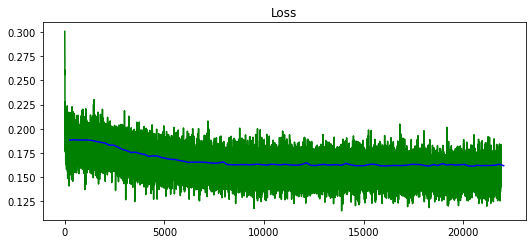

In [34]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

temp = torch.FloatTensor(train_loss_history).to('cpu')
val_temp = torch.FloatTensor(val_loss_history).to('cpu')
x = range(len(temp))
val_x = np.arange(len(val_temp)) * 220 + 250
plt.title("Loss")
plt.plot(x, temp, color="green")
plt.plot(val_x, val_temp, color='blue')

plt.show()

###Test Result###

In [31]:
# test_tensor = TensorDataset(torch.FloatTensor(X_val).to(device), torch.FloatTensor(y_val).view(-1,1).to(device))
prediction = oncf.forward(torch.FloatTensor(X_test).to(device))
loss = torch.sqrt(nn.MSELoss()(prediction, torch.FloatTensor(y_test).view(-1,1).to(device)))
print(loss)

tensor(0.1582, device='cuda:0', grad_fn=<SqrtBackward0>)


###CNN###

In [18]:
from torch.nn.modules.activation import Sigmoid
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.fc = nn.Sequential(           
            nn.Linear(64 * 28 * 60, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        #print(x)
        res = self.cnn(x)
        res = torch.flatten(res, 1)
        res = self.fc(res)
        #print(x)
        return res

    def train_net(self, train_dl, test_dl, epochs=9):
        self.to(device)
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        train_loss_history = []
        val_loss_history = []
        for epoch in range(epochs):
            self.train()
            train_loss = 0
            count = 0
            for (data,labels) in train_dl:
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                prediction = self(data)
                loss = torch.sqrt(nn.MSELoss()(prediction, labels))
                loss.backward()
                optimizer.step()
                train_loss_history.append(loss)
                train_loss += loss
                count += 1
            train_loss /= count
            self.eval()
            test_loss = self.test(test_dl)
            val_loss_history.append(test_loss)
            print ('Epoch:%d, train loss: %f, validation loss: %f'%(epoch+1, train_loss, test_loss))
        return train_loss_history, val_loss_history
      
    def test(self, test_dl):
        self.eval()
        loss = 0
        count = 0
        with torch.no_grad():
            for (data,label) in test_dl:
                data, label = data.to(device), label.to(device)
                prediction = self(data)
                loss += torch.sqrt(nn.MSELoss()(prediction, label))
                count += 1

        return loss / count

In [23]:
cnn = CNN().to(device)
train_loss_history, val_loss_history = cnn.train_net(train_dl, test_dl, epochs=10)

Epoch:1, train loss: 0.187781, validation loss: 0.188449
Epoch:2, train loss: 0.184136, validation loss: 0.188649
Epoch:3, train loss: 0.183498, validation loss: 0.189233
Epoch:4, train loss: 0.180994, validation loss: 0.185410
Epoch:5, train loss: 0.178323, validation loss: 0.185402
Epoch:6, train loss: 0.175512, validation loss: 0.181350
Epoch:7, train loss: 0.171644, validation loss: 0.178845
Epoch:8, train loss: 0.167239, validation loss: 0.174828
Epoch:9, train loss: 0.162126, validation loss: 0.171457
Epoch:10, train loss: 0.157704, validation loss: 0.170903


###Loss Curve###

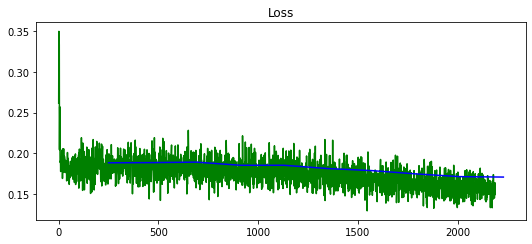

In [24]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

temp = torch.FloatTensor(train_loss_history).to('cpu')
val_temp = torch.FloatTensor(val_loss_history).to('cpu')
x = range(len(temp))
val_x = np.arange(len(val_temp)) * 220 + 250
plt.title("Loss")
plt.plot(x, temp, color="green")
plt.plot(val_x, val_temp, color='blue')

plt.show()

###Test Result###

In [28]:
prediction = cnn.to('cpu').forward(torch.FloatTensor(X_test))
loss = torch.sqrt(nn.MSELoss()(prediction, torch.FloatTensor(y_test).view(-1,1)))
print(loss)

tensor(0.1654, grad_fn=<SqrtBackward0>)
